In [2]:
import timeit


In [3]:
start = timeit.default_timer()

import os

imdb_dir='C:/Users/Alekh/Downloads/aclImdb_v1/aclImdb'
train_dir=os.path.join(imdb_dir,'train')

labels=[]
texts=[]

for label_type in ['neg','pos']:
    dir_name=os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)
stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in {}".format(execution_time))

Program Executed in 385.18184866058084


In [6]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [30]:
start = timeit.default_timer()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100
training_samples=200
validation_samples=10000
max_words=10000

tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)

word_index=tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))

data=pad_sequences(sequences,maxlen=maxlen)
labels=np.asarray(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

indices=np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]


x_train=data[:training_samples]
y_train=labels[:training_samples]

x_val=data[training_samples:training_samples+validation_samples]
y_val=labels[training_samples:training_samples+validation_samples]

stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in {}".format(execution_time))

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of labels tensor: (25000,)
Program Executed in 13.291780970125728


In [31]:
x_val.shape

(10000, 100)

In [32]:
x_train.shape

(200, 100)

In [17]:


embeddings_index={}
f=open('C:/Users/Alekh/Downloads/gensim_glove.6B.50d/gensim_glove.6B.50d.txt',encoding="utf8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400001 word vectors


In [21]:
x_train

array([[   0,    0,    0, ...,    3,   84,   17],
       [   5,    1,  205, ...,    2, 5226,  302],
       [   1,  113,    6, ...,   54,   10,  194],
       ...,
       [ 946,    1,  797, ...,   91,  201,  307],
       [3386,   22,  235, ...,  857,   28,   83],
       [  16,    1, 1882, ...,    8,  172,  133]])

In [24]:
type(word_index)

dict

### Preparing the glove word embeddings matrix

In [33]:
embedding_dim=50

embedding_matrix=np.zeros((max_words,embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [34]:
embedding_matrix.shape

(10000, 50)

In [35]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26818001,  0.14346001, -0.27877   , ..., -0.63209999,
        -0.25027999, -0.38097   ],
       ...,
       [ 0.080631  ,  0.42407   , -0.80875999, ..., -0.094323  ,
        -0.3558    , -0.57837999],
       [ 0.55150998, -0.55568999, -0.74370998, ...,  0.63006002,
        -0.49641001,  0.2423    ],
       [-0.36245999,  0.80723   , -0.1154    , ..., -0.070781  ,
         0.17387   , -0.22424001]])

Defining Model

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

Training & Evaluaions

In [39]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history=model.fit(x_train,y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(x_val,y_val)
                 )

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9616 - acc: 0.5500 - val_loss: 0.9043 - val_acc: 0.4975
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5842 - acc: 0.6950 - val_loss: 0.8881 - val_acc: 0.5030
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3761 - acc: 0.8850 - val_loss: 0.7795 - val_acc: 0.4975
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2516 - acc: 0.9000 - val_loss: 0.8587 - val_acc: 0.5014
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1661 - acc: 0.9750 - val_loss: 1.2472 - val_acc: 0.5017
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1441 - acc: 0.9600 - val_loss: 0.8452 - val_acc: 0.5048
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0522 - acc: 1.0000 - val_loss: 0.8811 - val_acc: 0.5036
Epoch 8/10
200/200 [========

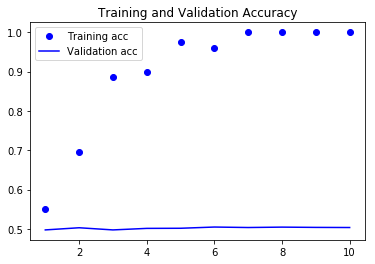

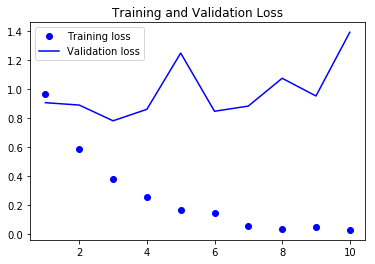

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
acc=history.history['acc']
val_acc=history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc' )
plt.plot(epochs,val_acc,'b',label='Validation acc' )
plt.title('Training and Validation Accuracy')

plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss' )
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

